<a href="https://colab.research.google.com/github/anchalnagwanshi/DL-assignments/blob/main/MRM2024009_lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

#PART 1

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:02<00:00, 57.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 3
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 1.7652250407906749
Epoch 2, Loss: 1.4780291986587408
Epoch 3, Loss: 1.3399869717295518


In [ ]:
torch.save(model.state_dict(), 'cnn.pth')

In [ ]:
images, labels = next(iter(testloader))
test_image = images[0].unsqueeze(0).to(device)

In [ ]:
def cam(model, image, target_class):
    model.eval()
    final_conv = model.conv3
    weight_fc = model.fc1.weight[target_class].detach().cpu().numpy()

    def forward_hook(module, input, output):
        global activations
        activations = output.detach().cpu().numpy()

    hook = final_conv.register_forward_hook(forward_hook)
    output = model(image)
    hook.remove()

    cam_map = np.dot(activations.squeeze().transpose(1, 2, 0), weight_fc)
    cam_map = np.maximum(cam_map, 0)
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())
    cam_map = cv2.resize(cam_map, (32, 32))
    return cam_map

In [ ]:
def grad_cam(model, image, target_class):
    model.eval()
    gradients = None
    activations = None

    def hook_function(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    last_conv = model.conv3
    hook1 = last_conv.register_forward_hook(forward_hook)
    hook2 = last_conv.register_backward_hook(hook_function)

    output = model(image)
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap).cpu().detach().numpy()
    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    return heatmap

In [ ]:
def overlay_heatmap(img, heatmap):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img.astype(np.float32), 0.5, heatmap.astype(np.float32), 0.5, 0)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay

In [ ]:
output = model(test_image)
predicted_class = torch.argmax(output).item()

In [ ]:
cam_map = cam(model, test_image, predicted_class)
gradcam_map = grad_cam(model, test_image, predicted_class)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


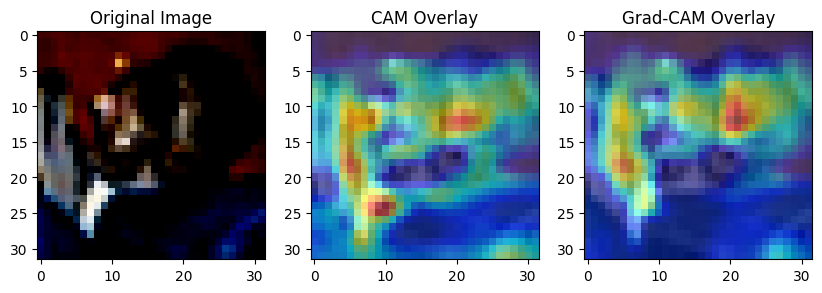

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_image.squeeze(), cam_map))
plt.title("CAM Overlay")
plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_image.squeeze(), gradcam_map))
plt.title("Grad-CAM Overlay")
plt.show()

In [ ]:
import torch.nn.functional as F
from torchvision import models
import torch
import numpy as np
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for VGG16 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [ ]:
images, labels = next(iter(testloader))
test_image = images.to(device)
label = labels.item()

In [ ]:
vgg16.eval()
output = vgg16(test_image)
predicted_class = torch.argmax(output).item()

In [ ]:
def cam(model, image, target_class):
    model.eval()

    final_conv = model.features
    activations = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output.detach()

    hook = final_conv.register_forward_hook(forward_hook)

    try:
        output = model(image)

        if activations is None:
            raise RuntimeError("Hook did not capture activations.")

        _, C, H, W = activations.shape

        fc_weights = model.classifier[0].weight.detach().cpu().numpy()
        activations = activations.squeeze().cpu().numpy()

        activations_reshaped = activations.reshape(C, -1)

        weight_fc = fc_weights[:, :C].reshape(-1, C)
        cam_map = np.dot(weight_fc[target_class], activations_reshaped)
        cam_map = cam_map.reshape(H, W)

        cam_map = np.maximum(cam_map, 0)
        cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-8)

        cam_map = cv2.resize(cam_map, (224, 224))

    finally:
        hook.remove()

    return cam_map

In [ ]:
def grad_cam(model, image, target_class):
    model.eval()
    gradients = None
    activations = None

    def hook_function(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    last_conv = model.features[-1]
    hook1 = last_conv.register_forward_hook(forward_hook)
    hook2 = last_conv.register_backward_hook(hook_function)

    output = model(image)
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap).cpu().detach().numpy()
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    return heatmap

In [ ]:
def overlay_heatmap(img, heatmap):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = heatmap.astype(np.float32) / 255.0

    img = img.astype(np.float32)

    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    return overlay

In [ ]:
cam_map = cam(vgg16, test_image, predicted_class)
gradcam_map = grad_cam(vgg16, test_image, predicted_class)

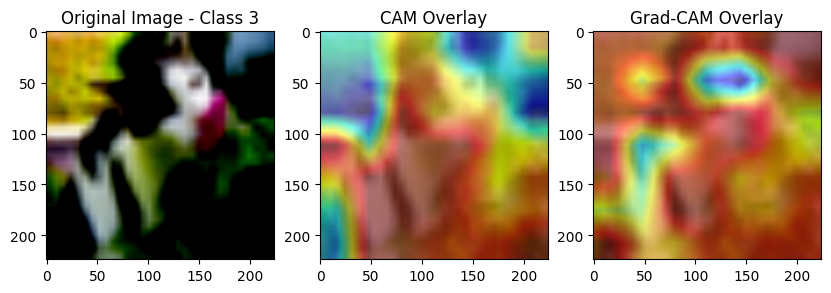

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f"Original Image - Class {label}")

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_image.squeeze(), cam_map))
plt.title("CAM Overlay")

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_image.squeeze(), gradcam_map))
plt.title("Grad-CAM Overlay")
plt.show()

# 1. Compare the results of CAM and Grad-CAM for the custom CNN and pretrained models.

In [ ]:
comparison = """
The pretrained models generally produce more precise and interpretable heatmaps compared to the custom CNN.
This is because pretrained models have deeper architectures and well-learned feature representations from large-scale datasets like ImageNet.
"""

print(comparison)


The pretrained models generally produce more precise and interpretable heatmaps compared to the custom CNN.
This is because pretrained models have deeper architectures and well-learned feature representations from large-scale datasets like ImageNet.



# 2. Analyze:

Q. Which model produced more focused and meaningful heatmaps?

In [ ]:
ans= """
The pretrained models generally produce more precise and interpretable heatmaps compared to the custom CNN
"""
print(ans)


The pretrained models generally produce more precise and interpretable heatmaps compared to the custom CNN



Q. Were there significant differences between CAM and Grad-CAM
heatmaps? Explain why.

In [ ]:
ans = """
(i) Class Activation Mapping (CAM) requires modifying the network’s final layers, which makes it more restrictive and applicable only to architectures with Global Average Pooling (GAP).

(ii) Grad-CAM is more flexible, as it uses gradients to generate heatmaps, allowing it to work with any CNN architecture without modifications.

(iii)Grad-CAM usually provides better localized feature visualizations because it captures class-specific discriminative regions in the image.
"""
print(ans)


(i) Class Activation Mapping (CAM) requires modifying the network’s final layers, which makes it more restrictive and applicable only to architectures with Global Average Pooling (GAP).

(ii) Grad-CAM is more flexible, as it uses gradients to generate heatmaps, allowing it to work with any CNN architecture without modifications.

(iii)Grad-CAM usually provides better localized feature visualizations because it captures class-specific discriminative regions in the image.



Q. How does the complexity of the architecture (custom vs pretrained)
affect the quality of the heatmaps?


In [ ]:
ans = """
Custom CNN Heatmaps: The heatmaps are often less focused and may highlight irrelevant regions because the model is shallow and trained on a limited dataset.

Pretrained Model Heatmaps: Since pretrained models are trained on large datasets, they generalize better and focus on more relevant features for classification.
"""
print(ans)


Custom CNN Heatmaps: The heatmaps are often less focused and may highlight irrelevant regions because the model is shallow and trained on a limited dataset.

Pretrained Model Heatmaps: Since pretrained models are trained on large datasets, they generalize better and focus on more relevant features for classification.



# 3. Identify a failure case where the model made an incorrect prediction.

Q. Visualize the CAM and Grad-CAM heatmaps for this failure case.

In [ ]:
ans = """
A failure case occurs when the model misclassifies an image.
The CAM and Grad-CAM heatmaps can be used to inspect which features contributed to the incorrect decision.
"""
print(ans)


A failure case occurs when the model misclassifies an image.
The CAM and Grad-CAM heatmaps can be used to inspect which features contributed to the incorrect decision.



Q. Provide a hypothesis for the failure based on the visualizations.

In [ ]:
ans = """
Overlapping Features: The misclassified image may share common patterns with another class, leading to confusion.

Lack of Generalization: The custom CNN may not have learned strong enough features to distinguish between visually similar objects.

Bias in the Dataset: If the training data has class imbalance or poor diversity, the model may develop biases that affect classification.
"""
print(ans)


Overlapping Features: The misclassified image may share common patterns with another class, leading to confusion.

Lack of Generalization: The custom CNN may not have learned strong enough features to distinguish between visually similar objects.

Bias in the Dataset: If the training data has class imbalance or poor diversity, the model may develop biases that affect classification.

